In [3]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey


In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.011*"israeli" + 0.010*"kill" + 0.010*"people" + 0.009*"attack" + '
  '0.008*"government" + 0.008*"state" + 0.008*"war" + 0.007*"turkish" + '
  '0.006*"soldier" + 0.006*"greek"'),
 (1,
  '0.018*"write" + 0.013*"bike" + 0.012*"article" + 0.007*"steal" + '
  '0.007*"rider" + 0.007*"time" + 0.006*"number" + 0.006*"ride" + 0.006*"look" '
  '+ 0.005*"find"'),
 (2,
  '0.034*"team" + 0.026*"game" + 0.018*"year" + 0.017*"play" + 0.015*"player" '
  '+ 0.014*"hockey" + 0.011*"playoff" + 0.011*"wing" + 0.010*"win" + '
  '0.009*"pen"'),
 (3,
  '0.014*"people" + 0.013*"write" + 0.009*"believe" + 0.008*"reason" + '
  '0.006*"article" + 0.006*"evidence" + 0.006*"question" + 0.006*"time" + '
  '0.006*"give" + 0.006*"first"')]


In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9297,"write, bike, article, steal, rider, time, numb...","[summary, worth, expire, keyword, ducati, gts,..."
1,1,2.0,0.6751,"team, game, year, play, player, hockey, playof...","[group, article, write, course, time, prior, t..."
2,2,3.0,0.8315,"people, write, believe, reason, article, evide...","[write, new, group, maybe, cover, already, cur..."
3,3,0.0,0.5916,"israeli, kill, people, attack, government, sta...","[article, write, article, write, article, writ..."
4,4,1.0,0.4824,"write, bike, article, steal, rider, time, numb...","[goalie_mask, organization, ist, article, writ..."
5,5,1.0,0.6477,"write, bike, article, steal, rider, time, numb...","[bmw_moa_member, read, internet, access, syste..."
6,6,1.0,0.7257,"write, bike, article, steal, rider, time, numb...","[require, organization, article, write, articl..."
7,7,1.0,0.7873,"write, bike, article, steal, rider, time, numb...","[looking, movie, bike, university, latech, sum..."
8,8,3.0,0.9877,"people, write, believe, reason, article, evide...","[organization, university, follow, thread, tal..."
9,9,0.0,0.6230,"israeli, kill, people, attack, government, sta...","[day, night, round, male, inhabitant, article,..."


In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9632,"israeli, kill, people, attack, government, state, war, turkish, soldier, greek","[armenian, genocide, people, article, write, ranada, ermeniler, boyle, icin, bulunan, oldurmuler..."
1,1.0,0.9810,"write, bike, article, steal, rider, time, number, ride, look, find","[distribution, organization, originator, seq, message, write, unauthenticated, user, user, neces..."
2,2.0,0.9923,"team, game, year, play, player, hockey, playoff, wing, win, pen","[result, game, play, organization, keyword, boxscore, nhl, result, game, play, standing, adam, c..."
3,3.0,0.9958,"people, write, believe, reason, article, evidence, question, time, give, first","[arrogance, article, write, write, article, write, truth, absolute, scripture, truth, therefore,..."


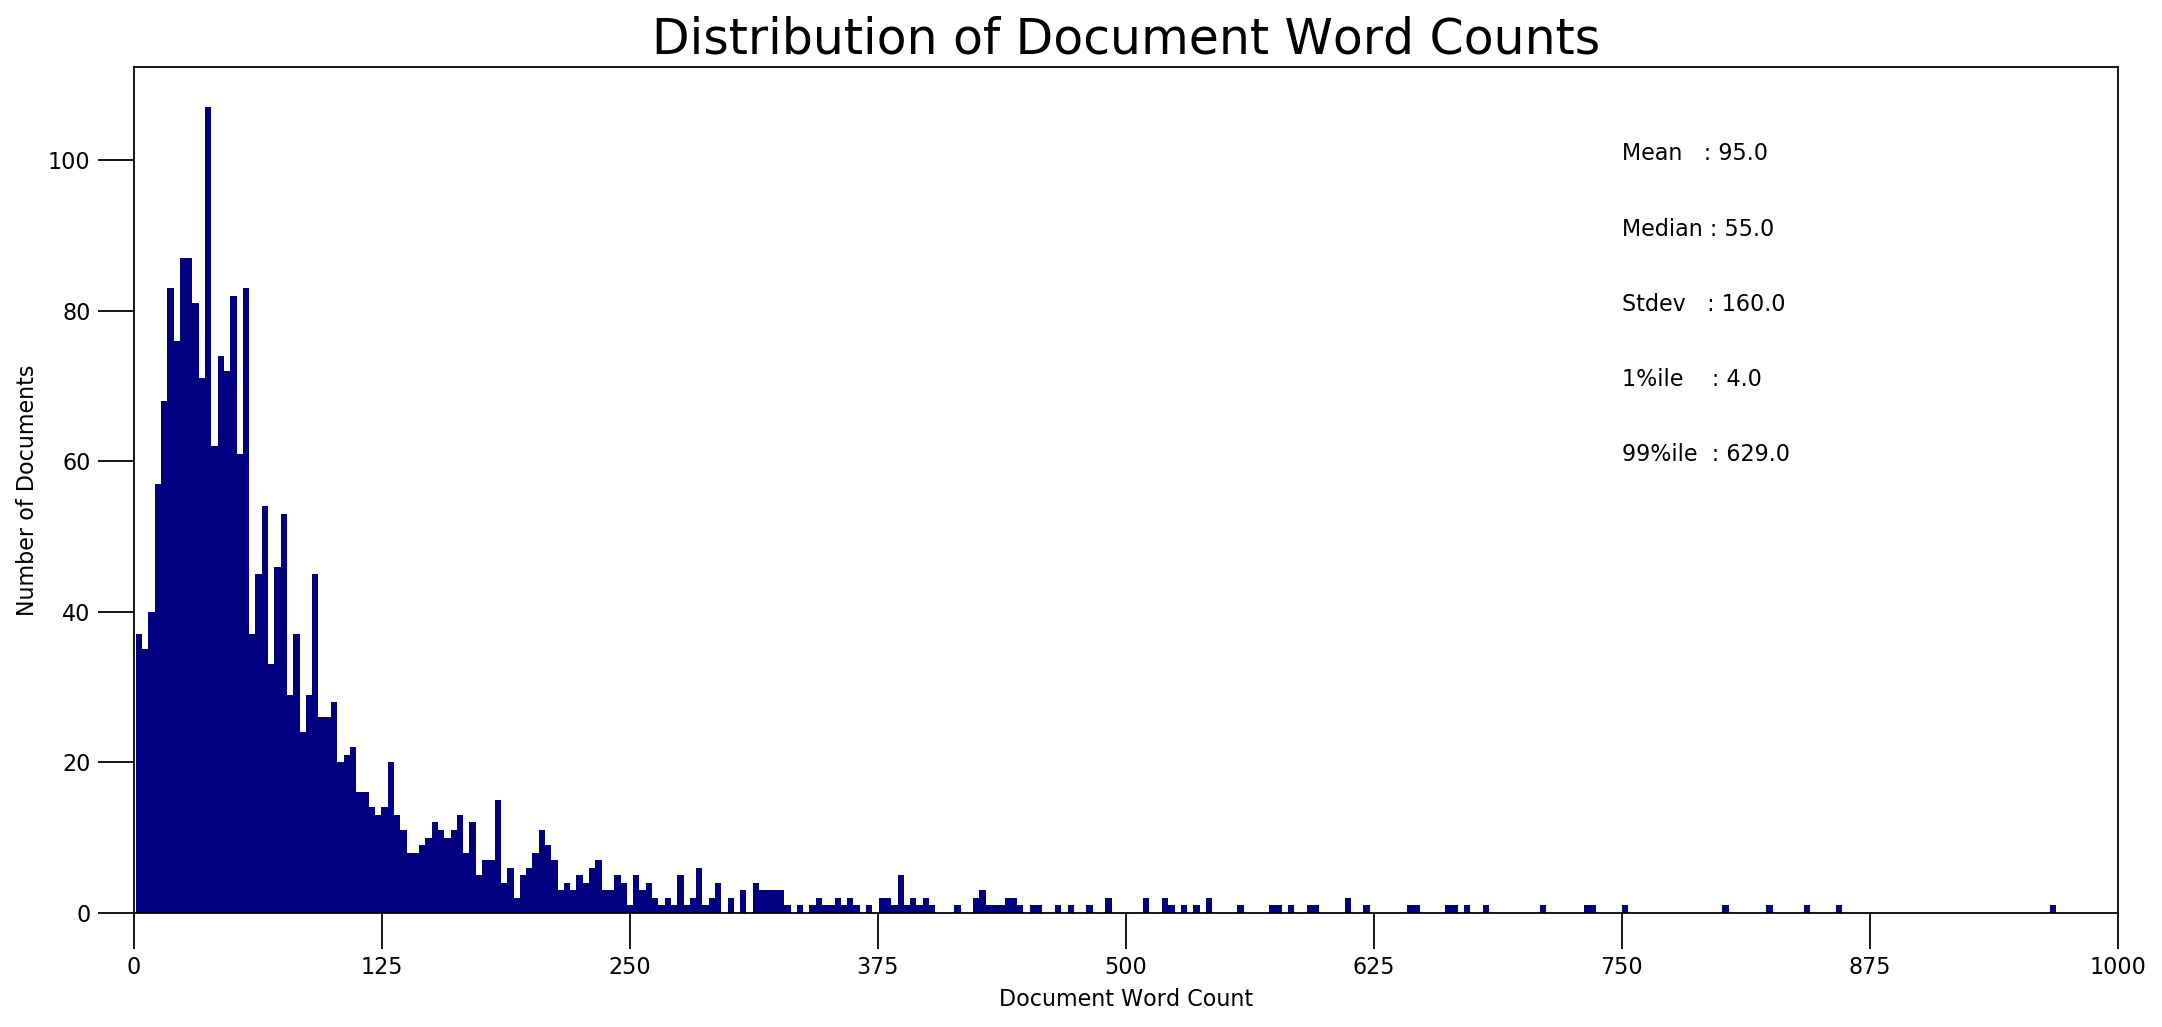

In [17]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

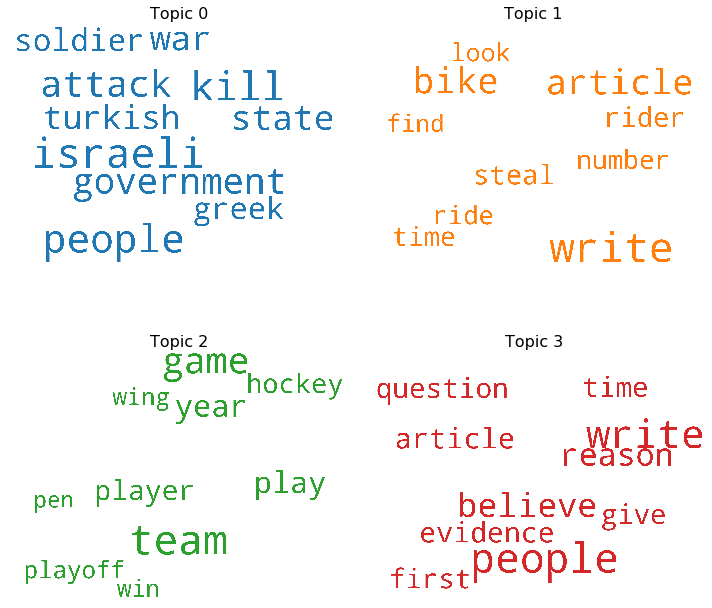

In [25]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

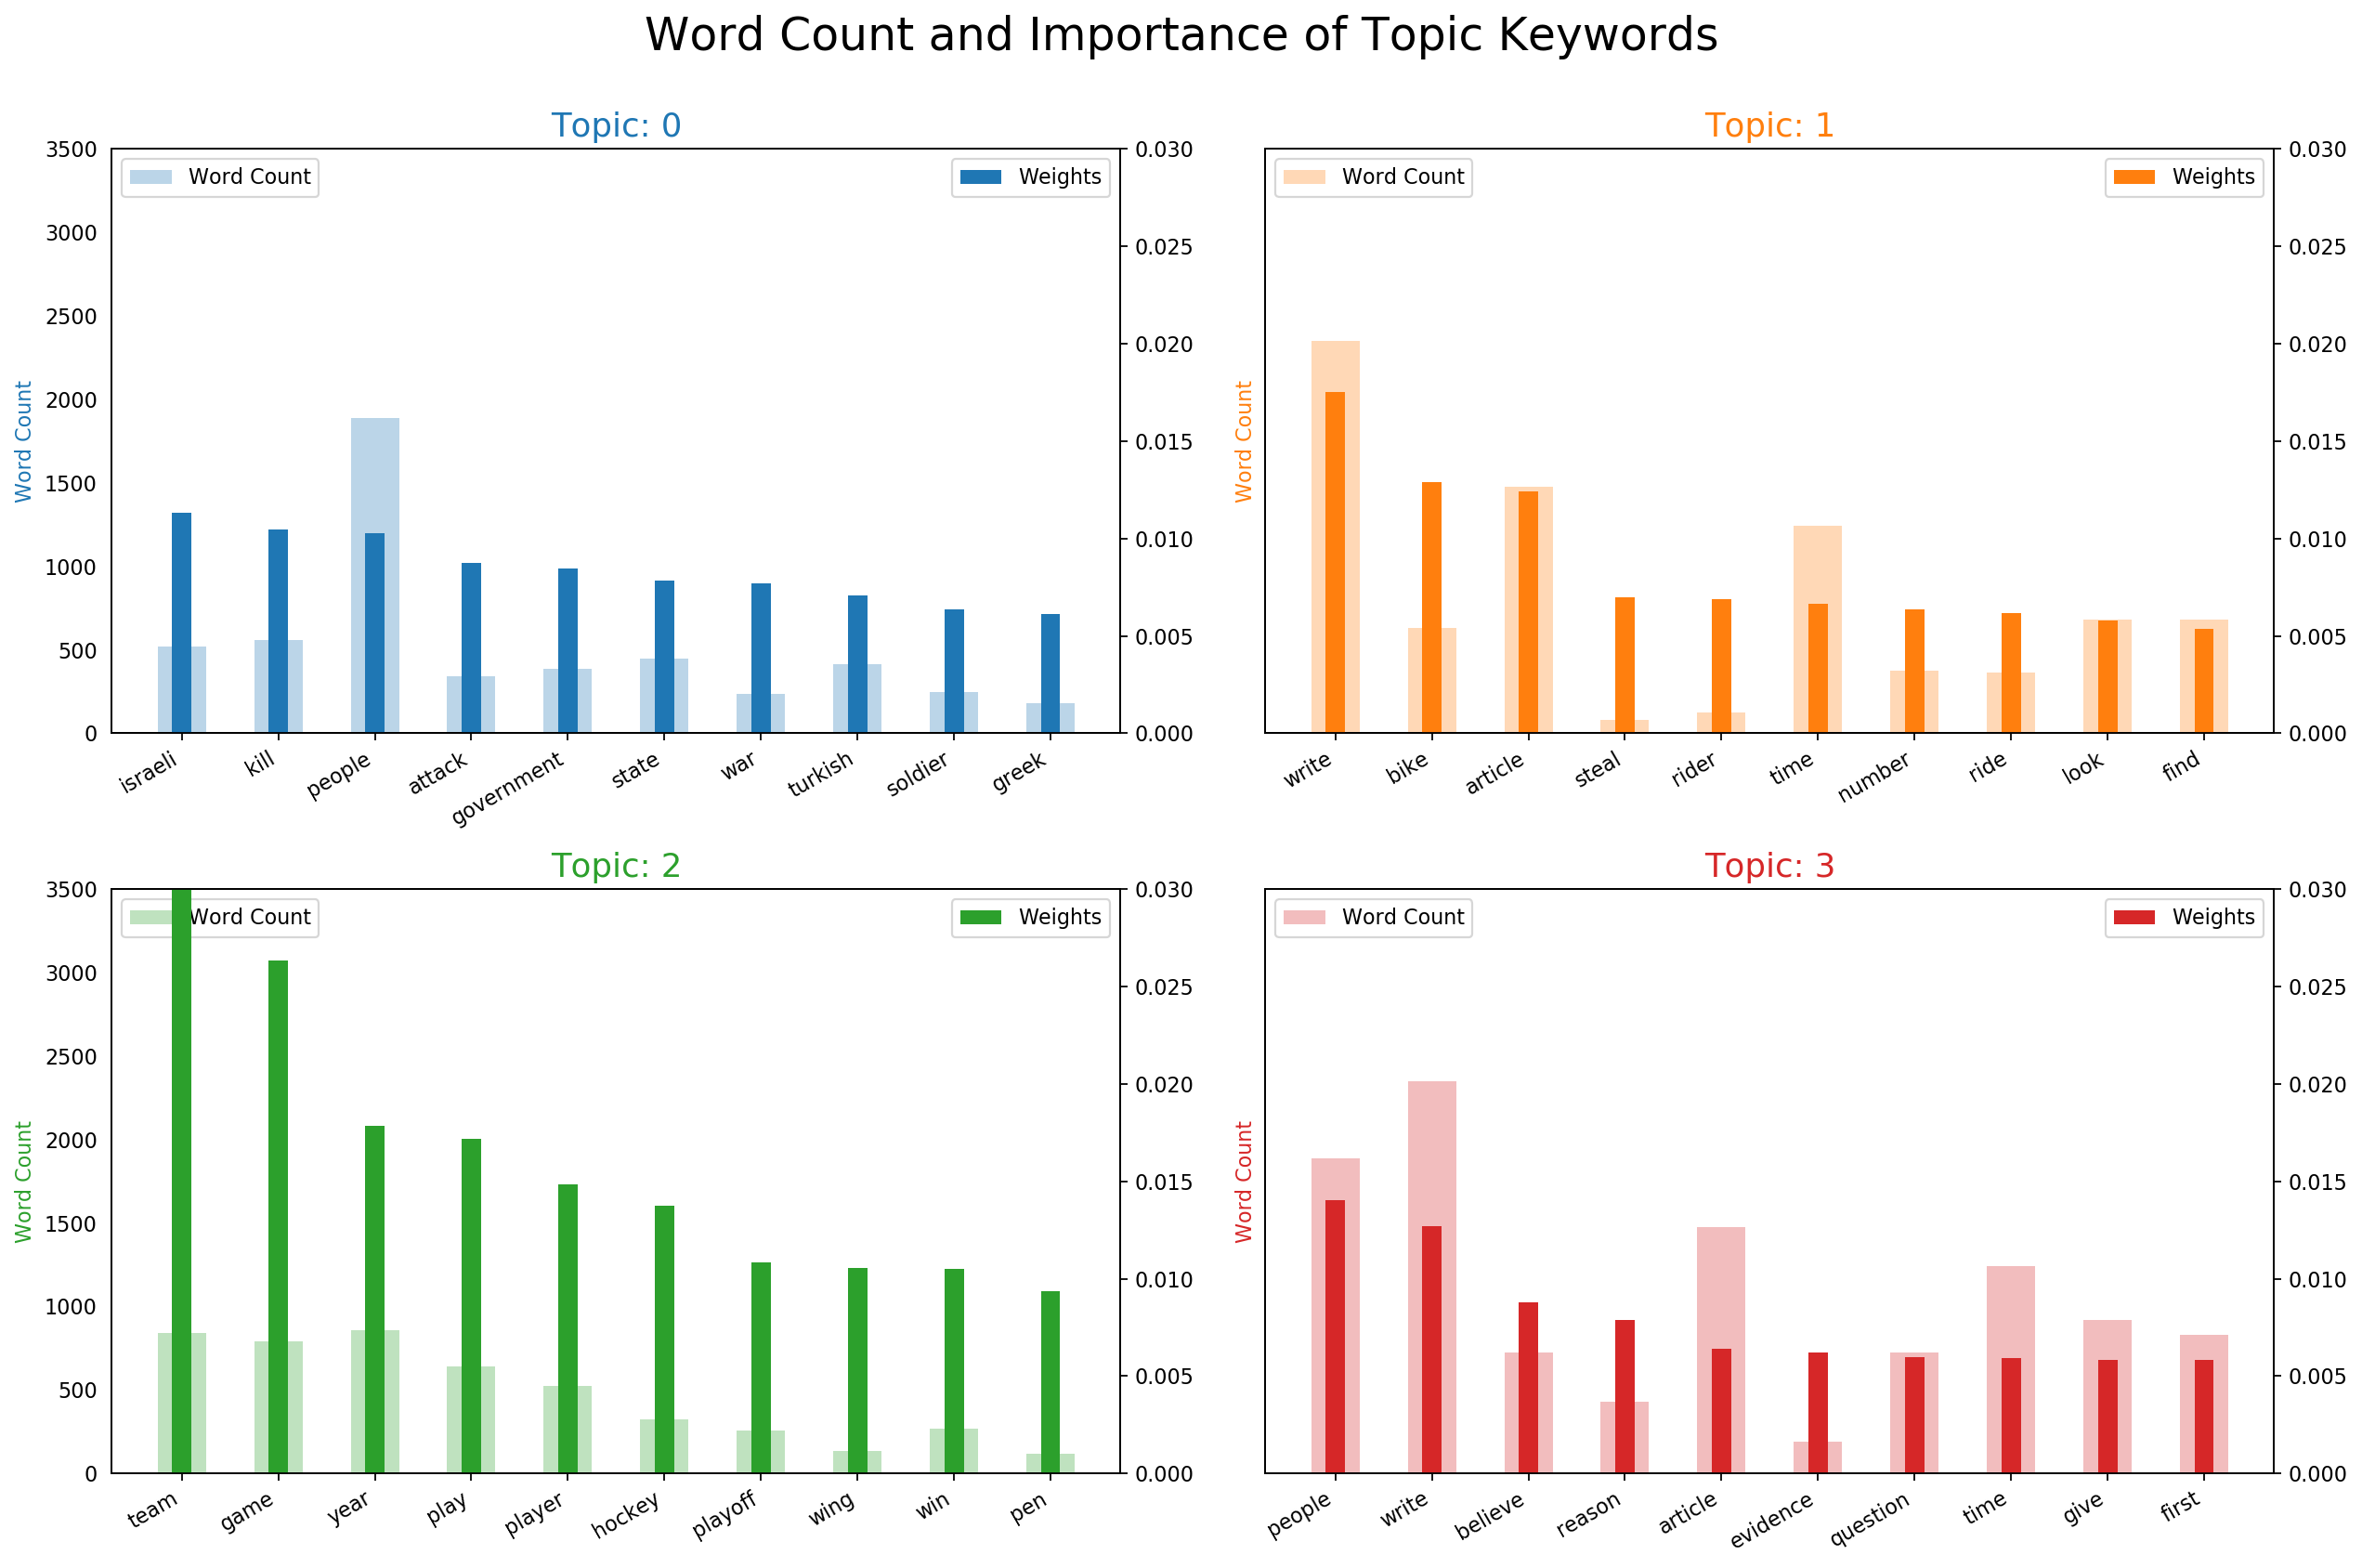

In [26]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [27]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

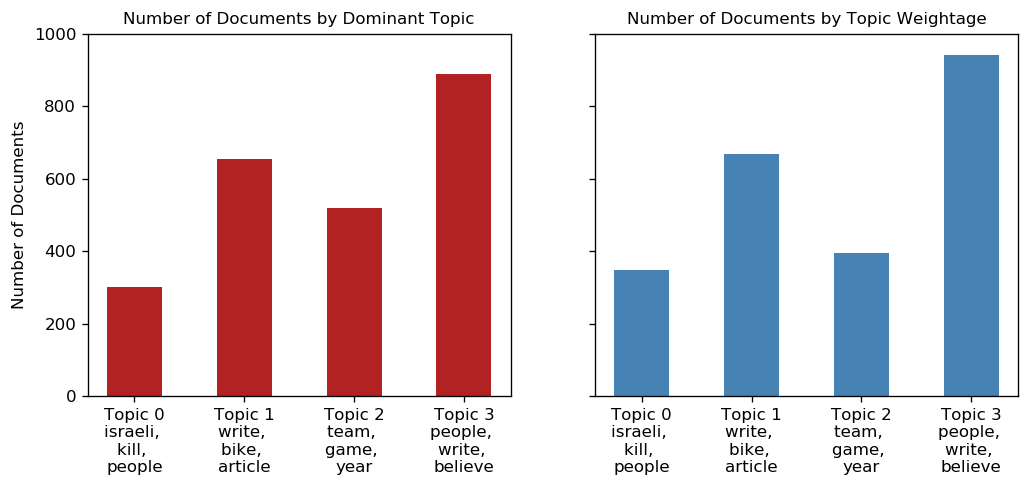

In [28]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [33]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2343 samples in 0.001s...
[t-SNE] Computed neighbors for 2343 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2343
[t-SNE] Computed conditional probabilities for sample 2000 / 2343
[t-SNE] Computed conditional probabilities for sample 2343 / 2343
[t-SNE] Mean sigma: 0.039800
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.875343
[t-SNE] KL divergence after 1000 iterations: 0.537332


Loading BokehJS ...

In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.138181  0.222029       1        1  44.075333
0     -0.187216 -0.225683       2        1  21.829344
1      0.082983  0.078135       3        1  21.678461
2      0.242415 -0.074481       4        1  12.416867, topic_info=       Term        Freq        Total Category  logprob  loglift
1025   team  961.000000   961.000000  Default  30.0000  30.0000
565    game  737.000000   737.000000  Default  29.0000  29.0000
43     play  481.000000   481.000000  Default  28.0000  28.0000
275    year  909.000000   909.000000  Default  27.0000  27.0000
0      bike  629.000000   629.000000  Default  26.0000  26.0000
...     ...         ...          ...      ...      ...      ...
242    well  167.816055   764.674377   Topic4  -5.1151   0.5695
52    write  199.024246  2388.646973   Topic4  -4.9446  -0.3989
263    last  131.310257   420.779846   Topic4  -5.3604   0.9216
49     time  157.109406  1211.615967   Topic4  -5.1810   0.0433
134    show  121.880341   373.802338   Topic4  -5.4349   0.9654

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
407       1  0.996343    answer
154       2  0.993990      arab
410       1  0.995292  argument
451       2  0.997107  armenian
27        1  0.433622   article
...     ...       ...       ...
52        4  0.083311     write
1423      1  0.995902     wrong
275       2  0.319982      year
275       3  0.130852      year
275       4  0.548697      year

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])